In [102]:
# IoTID20 DoS vs Normal reproduction (paper-aligned, robust)
import warnings
warnings.filterwarnings("ignore")  # keep output clean; remove if you want full verbosity
import pandas as pd
import numpy as np
from pathlib import Path

CSV_PATH = "/Users/ssnipro/Desktop/pioneer/paper/data/iotid20.csv"

# SVM on the full 80 features is slow for ~100k rows; keep it off by default.
RUN_SVM_ON_ALL = True

# Light caps so SVM finishes quickly on reduced feature sets (GA/CFS)
SVM_KW = dict(kernel="rbf", gamma="scale", cache_size=1000, tol=1e-2, max_iter=2000)

RANDOM_STATE = 42

In [103]:
# DoS vs Normal Counts (Table 5 in esras paper)
df = pd.read_csv(CSV_PATH)
print("Columns loaded:", len(df.columns))
print(df.columns.tolist()[:10], "...")

print("\nUnique Cat values:", df["Cat"].dropna().astype(str).str.lower().unique()[:20])

is_dos    = df["Cat"].astype(str).str.lower().eq("dos")
is_normal = df["Cat"].astype(str).str.lower().isin(["normal", "benign"])
df = df[is_dos | is_normal].copy()

print("\nCounts by Category after filtering:\n", df["Cat"].value_counts())

# Map labels DoS→1, Normal/Benign→0
df["__y__"] = np.where(df["Cat"].astype(str).str.lower().eq("dos"), 1, 0)

print("\nTarget value counts (1=DoS, 0=Normal/Benign):")
print(df["__y__"].value_counts())
print("Shape after filter:", df.shape)

Columns loaded: 86
['Flow_ID', 'Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port', 'Protocol', 'Timestamp', 'Flow_Duration', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts'] ...

Unique Cat values: ['mirai' 'dos' 'scan' 'normal' 'mitm arp spoofing']

Counts by Category after filtering:
 Cat
DoS       59391
Normal    40073
Name: count, dtype: int64

Target value counts (1=DoS, 0=Normal/Benign):
__y__
1    59391
0    40073
Name: count, dtype: int64
Shape after filter: (99464, 87)


In [104]:
# clean data
DROP = ["Flow_ID", "Src_IP", "Dst_IP", "Timestamp", "Sub_Cat", "Label", "Cat"]
X = df.drop(columns=[c for c in DROP if c in df.columns], errors="ignore")
y = df["__y__"].astype(int)

print("\nDropped:", [c for c in DROP if c in df.columns])
print("Initial feature count:", X.shape[1], "Samples:", len(y))

# Replace inf/-inf and NaNs that can occur in rate columns
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)


Dropped: ['Flow_ID', 'Src_IP', 'Dst_IP', 'Timestamp', 'Sub_Cat', 'Label', 'Cat']
Initial feature count: 80 Samples: 99464


In [105]:
# remove constant & per-class-constant features
const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
per_class_const = []
for c in X.columns:
    nun = X.groupby(y)[c].nunique(dropna=False)
    if (nun <= 1).all():
        per_class_const.append(c)

drop_fix = sorted(set(const_cols) | set(per_class_const))
if drop_fix:
    print("Dropping constant / per-class-constant features:", drop_fix)
    X = X.drop(columns=drop_fix)

print("Feature count after cleanup:", X.shape[1])

Dropping constant / per-class-constant features: ['Bwd_Blk_Rate_Avg', 'Bwd_Byts/b_Avg', 'Bwd_Pkts/b_Avg', 'Fwd_Blk_Rate_Avg', 'Fwd_Byts/b_Avg', 'Fwd_PSH_Flags', 'Fwd_Pkts/b_Avg', 'Fwd_Seg_Size_Min', 'Fwd_URG_Flags', 'Init_Fwd_Win_Byts', '__y__']
Feature count after cleanup: 69


In [106]:
# Split (67/33, stratified)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (66640, 69)  Test: (32824, 69)


In [107]:
# Feature selection (CFS-like & GA-style surrogate)
def cfs_like(Xdf, yser, k=13, corr_cut=0.75):
    tmp = Xdf.copy()
    tmp["__y__"] = yser.values
    corrs = (
        tmp.corr(numeric_only=True)["__y__"]
        .drop("__y__", errors="ignore")
        .abs()
        .sort_values(ascending=False)
    )
    selected = []
    for f in corrs.index:
        if all(abs(Xdf[f].corr(Xdf[s])) < corr_cut for s in selected):
            selected.append(f)
        if len(selected) == k:
            break
    return selected

cfs_cols = cfs_like(X_train, y_train, k=13, corr_cut=0.75)
Xtr_cfs, Xte_cfs = X_train[cfs_cols], X_test[cfs_cols]
print("\nCFS-like (13) features:\n", cfs_cols)


CFS-like (13) features:
 ['ACK_Flag_Cnt', 'Pkt_Len_Max', 'Bwd_Pkts/s', 'Fwd_Pkts/s', 'Pkt_Len_Min', 'Pkt_Len_Std', 'Flow_IAT_Min', 'Bwd_IAT_Mean', 'Src_Port', 'Fwd_Pkt_Len_Std', 'Fwd_Header_Len', 'Flow_Duration', 'Bwd_Pkt_Len_Std']


In [108]:
from sklearn.feature_selection import SelectKBest, f_classif

# Clean any remaining target columns from feature matrix
X_train_clean = X_train.drop(columns=[c for c in X_train.columns if '__y__' in c], errors="ignore")
X_test_clean  = X_test.drop(columns=[c for c in X_test.columns  if '__y__' in c], errors="ignore")

# Apply SelectKBest using ANOVA F-test scoring
skb = SelectKBest(score_func=f_classif, k=13).fit(X_train_clean, y_train)
ga_cols = X_train_clean.columns[skb.get_support()].tolist()

# Reduced feature sets based on SelectKBest
Xtr_ga = X_train_clean[ga_cols]
Xte_ga = X_test_clean[ga_cols]

print("GA-style (SelectKBest) 13 features:\n", ga_cols)

GA-style (SelectKBest) 13 features:
 ['Dst_Port', 'Fwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean', 'Flow_Byts/s', 'Flow_Pkts/s', 'Pkt_Len_Max', 'Pkt_Len_Mean', 'SYN_Flag_Cnt', 'ACK_Flag_Cnt', 'Pkt_Size_Avg', 'Bwd_Seg_Size_Avg']


In [109]:
# Train models & compare
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

SETUPS = {
    "ALL": (X_train, X_test),
    "GA" : (Xtr_ga,  Xte_ga),
    "CFS": (Xtr_cfs, Xte_cfs),
}

# Core models; we’ll optionally add SVM on ALL based on flag
CLFS = {
    "DT" : DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RF" : RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE),
    "kNN": KNeighborsClassifier(n_neighbors=5),
}

# Always run SVM on reduced feature sets; optional on ALL
SVM = SVC(**SVM_KW)
REDUCED_FOR_SVM = {"GA": (Xtr_ga, Xte_ga), "CFS": (Xtr_cfs, Xte_cfs)}

rows = []

# Run DT/RF/kNN on all setups
for tag, (Xtr, Xte) in SETUPS.items():
    for name, clf in CLFS.items():
        clf.fit(Xtr, y_train)
        yhat = clf.predict(Xte)
        rows.append(dict(
            feats=tag, model=name,
            acc=accuracy_score(y_test, yhat),
            prec=precision_score(y_test, yhat, zero_division=0),
            rec=recall_score(y_test, yhat, zero_division=0),
            f1=f1_score(y_test, yhat, zero_division=0),
        ))

# Run SVM only on reduced sets by default (fast & stable)
for tag, (Xtr, Xte) in REDUCED_FOR_SVM.items():
    svm = SVC(**SVM_KW)
    svm.fit(Xtr, y_train)
    yhat = svm.predict(Xte)
    rows.append(dict(
        feats=tag, model="SVM",
        acc=accuracy_score(y_test, yhat),
        prec=precision_score(y_test, yhat, zero_division=0),
        rec=recall_score(y_test, yhat, zero_division=0),
        f1=f1_score(y_test, yhat, zero_division=0),
    ))

# Optionally include SVM on ALL features
if RUN_SVM_ON_ALL:
    svm_all = SVC(**SVM_KW)
    svm_all.fit(X_train, y_train)
    yhat = svm_all.predict(X_test)
    rows.append(dict(
        feats="ALL", model="SVM",
        acc=accuracy_score(y_test, yhat),
        prec=precision_score(y_test, yhat, zero_division=0),
        rec=recall_score(y_test, yhat, zero_division=0),
        f1=f1_score(y_test, yhat, zero_division=0),
    ))

res = pd.DataFrame(rows).sort_values(["feats","model"])
print("\n=== Results ===")
print(res.to_string(index=False))


=== Results ===
feats model      acc     prec      rec       f1
  ALL    DT 0.999513 0.999643 0.999541 0.999592
  ALL    RF 0.999573 0.999796 0.999490 0.999643
  ALL   SVM 0.865830 0.816636 0.999796 0.898982
  ALL   kNN 0.998111 0.999284 0.997551 0.998417
  CFS    DT 0.998934 0.999031 0.999184 0.999107
  CFS    RF 0.999238 0.999694 0.999031 0.999362
  CFS   SVM 0.996771 0.999078 0.995510 0.997291
  CFS   kNN 0.998111 0.999284 0.997551 0.998417
   GA    DT 0.998751 0.998776 0.999133 0.998954
   GA    RF 0.999208 0.999592 0.999082 0.999337
   GA   SVM 0.847307 0.796432 0.999847 0.886622
   GA   kNN 0.996466 0.998567 0.995510 0.997036


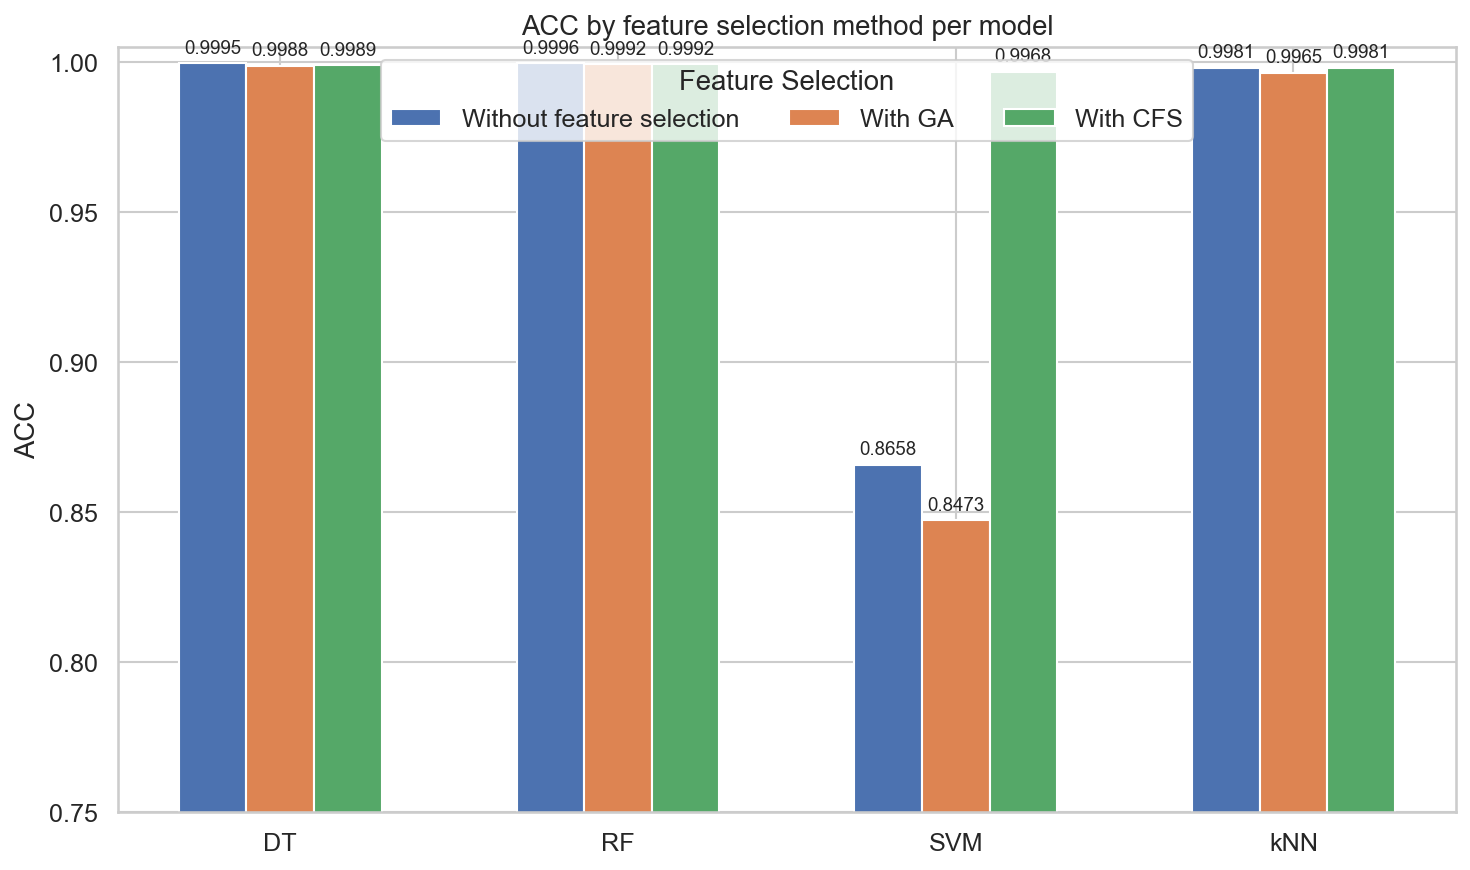

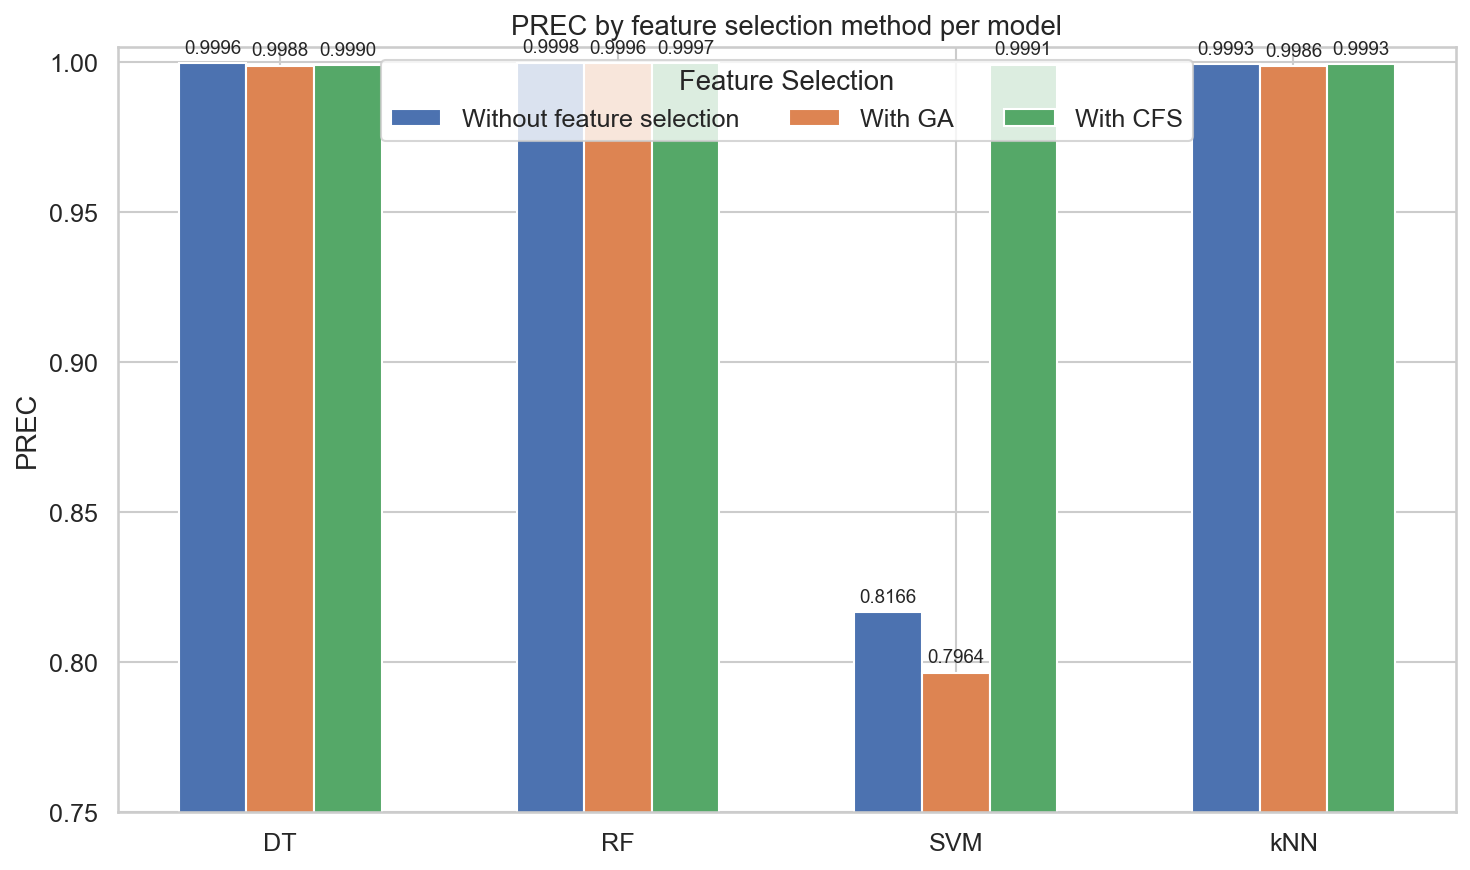

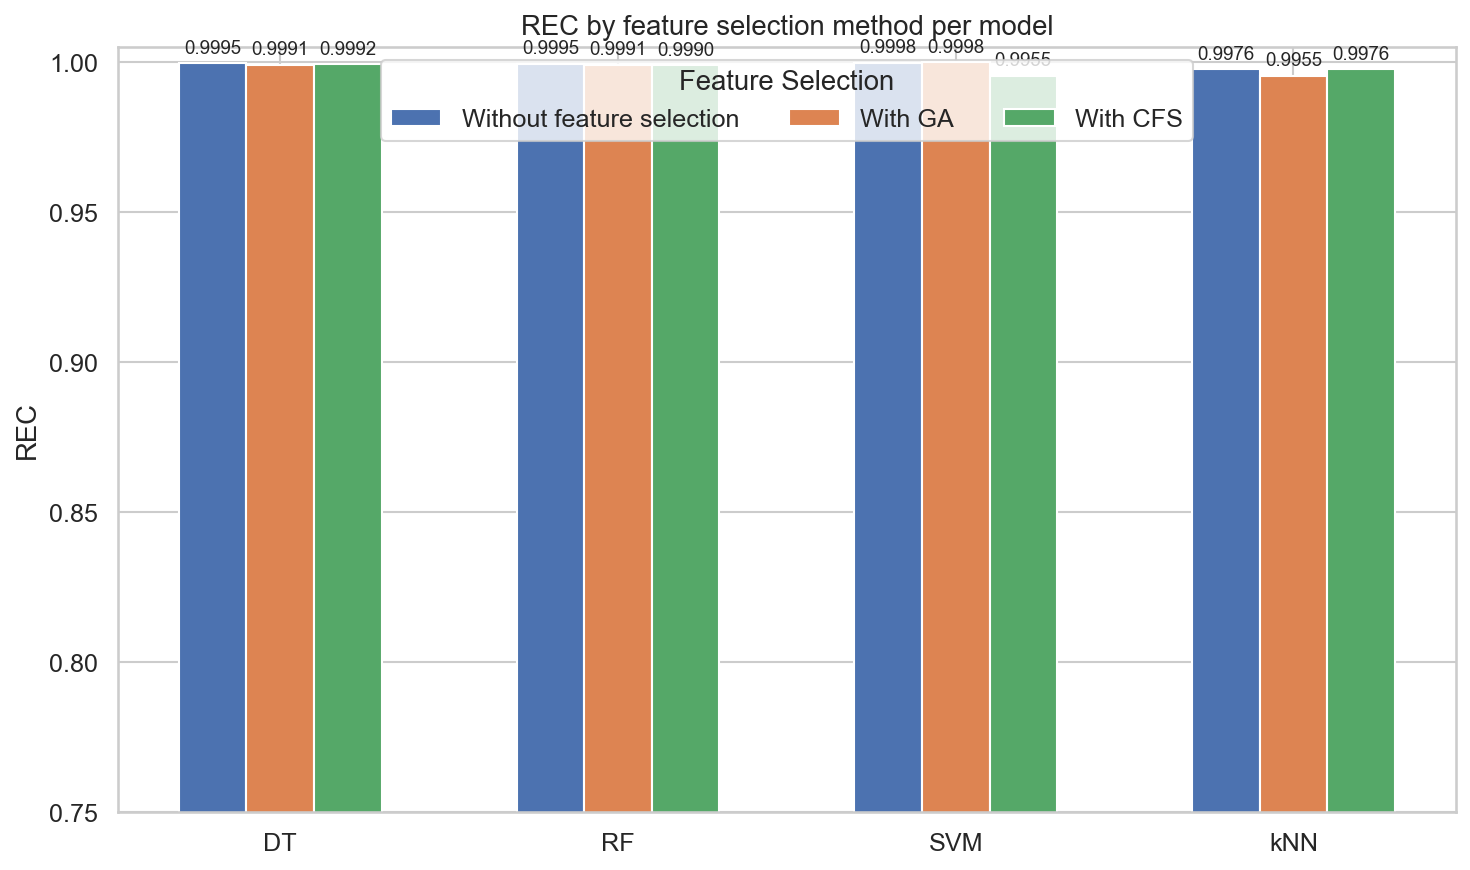

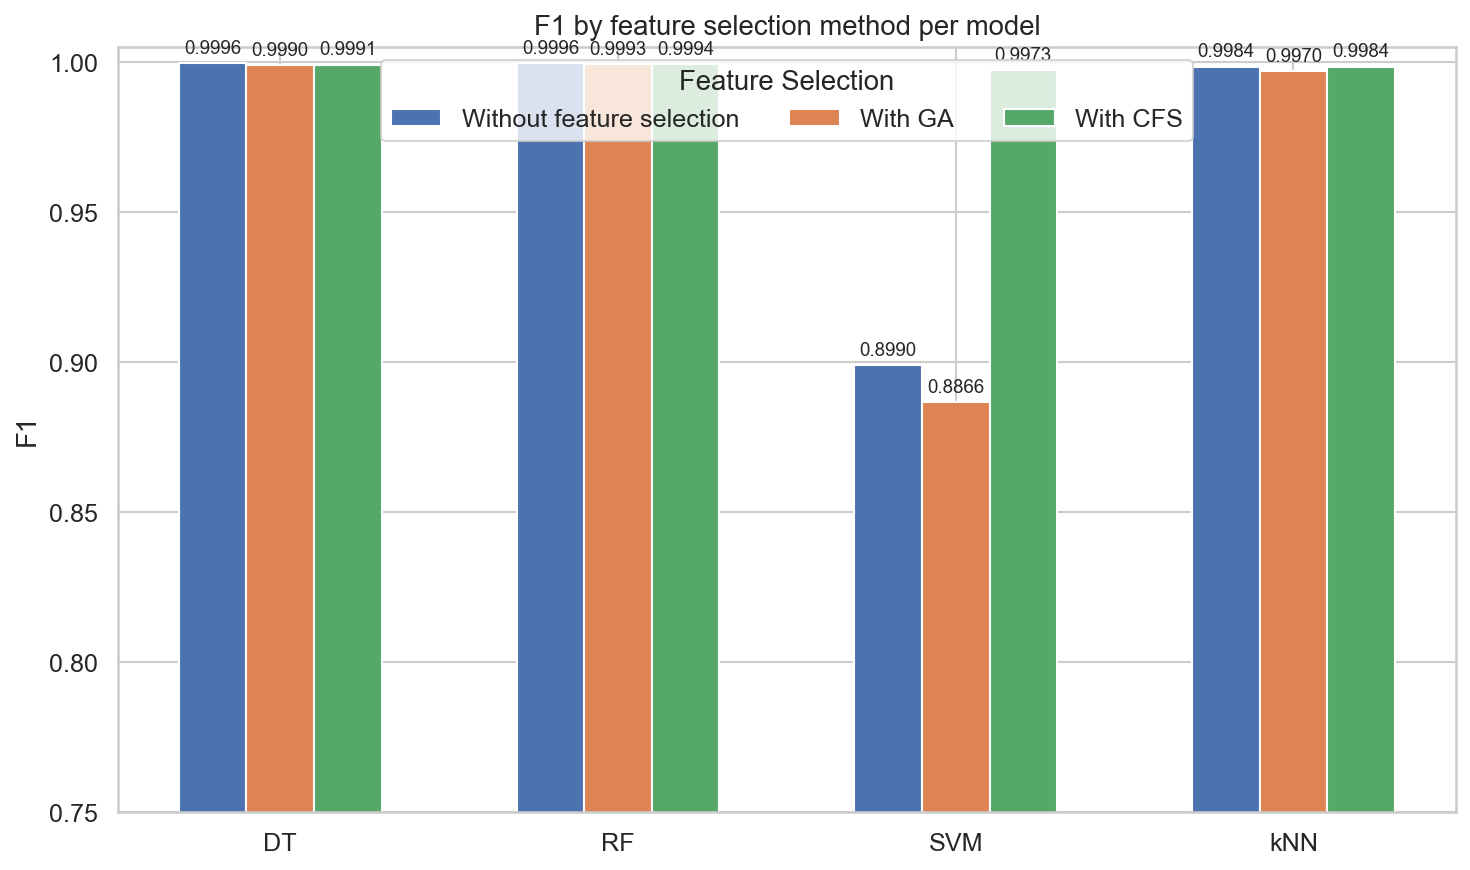

In [110]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

feats_order   = ["ALL", "GA", "CFS"]              # match paper ordering
models_order  = ["DT", "RF", "SVM", "kNN"]        # some rows may be missing (e.g., SVM on ALL)

def plot_metric_bars_by_model(res_df, metric="acc"):
    df = res_df.copy()

    # Clean up categories and order
    df["feats"] = pd.Categorical(df["feats"], feats_order, ordered=True)
    df["model"] = pd.Categorical(df["model"], models_order, ordered=True)
    df = df.sort_values(["model", "feats"])

    # Pivot: rows = model, columns = feature selection methods
    piv = df.pivot_table(index="model", columns="feats", values=metric)

    x = np.arange(len(models_order))  # one group per model
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))  # wider figure

    # For each feature method (ALL, GA, CFS), draw bars side by side per model
    for i, feat in enumerate(feats_order):
        if feat in piv.columns:
            vals = piv[feat].values
        else:
            vals = np.zeros(len(models_order))  # fallback
        bar = ax.bar(
            x + (i - 1) * width,
            vals,
            width,
            label={"ALL": "Without feature selection", "GA": "With GA", "CFS": "With CFS"}[feat]
        )
        for rect, val in zip(bar, vals):
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                val + 0.002,
                f"{val:.4f}",
                ha="center",
                va="bottom",
                fontsize=9,
                rotation=0
            )

    ax.set_title(f"{metric.upper()} by feature selection method per model")
    ax.set_ylabel(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(models_order)
    ax.set_ylim(0.75, 1.005)
    ax.legend(title="Feature Selection", loc="upper center", ncol=3)
    fig.tight_layout()
    plt.show()

# Run updated grouped plot
for metric in ["acc", "prec", "rec", "f1"]:
    plot_metric_bars_by_model(res, metric)


In [ ]:
# timing
import time, copy

def timed_once(clf, Xtr, Xte, ytr):
    t0 = time.time(); clf.fit(Xtr, ytr); t1 = time.time()
    tt = time.time(); clf.predict(Xte);  t2 = time.time()
    return (t1 - t0, t2 - tt)

print("\n=== Timing (s) ===")
for tag, (Xtr, Xte) in SETUPS.items():
    print(f"\n{tag}")
    for name, proto in CLFS.items():
        tr, te = timed_once(copy.deepcopy(proto), Xtr, Xte, y_train)
        print(f"{name:3}  train={tr:.4f}s  test={te:.4f}s")
# SVM timing on reduced sets
for tag, (Xtr, Xte) in REDUCED_FOR_SVM.items():
    tr, te = timed_once(SVC(**SVM_KW), Xtr, Xte, y_train)
    print(f"SVM({tag})  train={tr:.4f}s  test={te:.4f}s")
if RUN_SVM_ON_ALL:
    tr, te = timed_once(SVC(**SVM_KW), X_train, X_test, y_train)
    print(f"SVM(ALL)  train={tr:.4f}s  test={te:.4f}s")



=== Timing (s) ===

ALL
DT   train=0.1323s  test=0.0072s
RF   train=0.4925s  test=0.0314s
kNN  train=0.0139s  test=2.5972s

GA
DT   train=0.0376s  test=0.0021s
RF   train=0.3660s  test=0.0285s
kNN  train=0.0232s  test=0.8524s

CFS
DT   train=0.0711s  test=0.0024s
RF   train=0.4349s  test=0.0282s
kNN  train=0.0242s  test=0.6135s


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define your timing data
timing_data = {
    "DT":  {"ALL": (0.3305, 0.0154), "GA": (0.1042, 0.0065), "CFS": (0.2074, 0.0117)},
    "RF":  {"ALL": (2.5628, 0.1261), "GA": (1.6610, 0.1194), "CFS": (2.1295, 0.1100)},
    "kNN": {"ALL": (0.0382, 15.8794), "GA": (0.1070, 5.8465), "CFS": (0.0950, 4.3043)},
    "SVM": {"ALL": (41.4874, 20.4975), "GA": (24.3256, 23.2005), "CFS": (7.9079, 6.2735)},
}

models = ["DT", "RF", "SVM", "kNN"]
feats = ["ALL", "GA", "CFS"]

# Step 2: Build pandas DataFrames
train_df = pd.DataFrame(index=models, columns=feats)
test_df = pd.DataFrame(index=models, columns=feats)

for model in models:
    for feat in feats:
        if feat in timing_data.get(model, {}):
            train_df.loc[model, feat] = timing_data[model][feat][0]
            test_df.loc[model, feat] = timing_data[model][feat][1]

train_df = train_df.astype(float)
test_df = test_df.astype(float)

# Step 3: Define a plotting function
def plot_timing(df, title, ylabel):
    ax = df.plot(kind='bar', figsize=(10, 6), width=0.7)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Model")
    ax.set_ylim(0, df.max().max() * 1.2)
    ax.legend(title="Feature Selection", fontsize=10)
    for bars in ax.containers:
        ax.bar_label(bars, fmt="%.4f", label_type="edge", fontsize=9, padding=3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Step 4: Plot both graphs
plot_timing(train_df, "Training Time by Model and Feature Selection", "Seconds")
plot_timing(test_df, "Testing Time by Model and Feature Selection", "Seconds")
